In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

In [2]:
df = pd.read_csv('similar_data.csv', sep=';', header=0)
df.shape

(29, 13)

In [3]:
df.head()

,sub_mono,cover,sub_doble,sub_doble_intermitente,directo a cantar,trend,oscuro/claro/neutral,color_sub,likes,views,comments,saved,compartidos
0,1,0,0,0,1,1,n,white,67100,281500,225,8412,2042
1,1,1,0,0,1,0,c,none,7372,58400,66,729,52
2,0,1,0,0,0,0,n,white,5927,46000,67,725,242
3,1,1,1,0,1,0,n,white,110000,746100,614,18500,2509
4,1,0,0,0,0,1,o,white,6812,921000,651,836,54


# Functions used

In [4]:
def encode_strings(df,column,encode_column):
    string_to_number = {}
    current_number = 0  
    
    for i in df.index:
        color_sub_value = df[column][i]

        if color_sub_value not in string_to_number:
            string_to_number[color_sub_value] = current_number
            current_number += 1  
    
    df[encode_column] = df[column].map(string_to_number)
    
    return df


In [5]:
def plot_hist(df, columns_array):
    for column_name in columns_array:
        df[column_name].plot(kind='hist', bins=10, color='skyblue', edgecolor='black')
        plt.title('Histogram of ' + column_name)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.show()

In [6]:
from sklearn.neighbors import KernelDensity

def generate_samples_with_kde(df, num_estimated_samples):
    new_data = {}
    
    for column in df.columns:
        # Fit KDE to the data in each column
        kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
        kde.fit(df[[column]])
        
        new_samples = kde.sample(num_estimated_samples)
        
        new_samples = np.ravel(new_samples)
        
        new_data[column] = new_samples
    
    KDE_df = pd.DataFrame(new_data)
    
    return KDE_df

In [7]:
def bootstrap_samples(df, num_samples):
    """
    Generate bootstrap samples by resampling the rows of the DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data.
    - num_samples: Number of bootstrap samples to generate.

    Returns:
    - augmented_df: Augmented DataFrame containing the original data plus the bootstrap samples.
    """
    # Get the number of rows in the original DataFrame
    num_rows = len(df)
    
    # Initialize an empty DataFrame to store the augmented data
    augmented_df = pd.DataFrame()

    # Generate bootstrap samples
    for _ in range(num_samples):
        # Randomly sample rows with replacement
        bootstrap_rows = np.random.choice(num_rows, size=num_rows, replace=True)
        
        # Select the sampled rows from the original DataFrame
        bootstrap_sample = df.iloc[bootstrap_rows]
        
        # Concatenate the bootstrap sample with the augmented DataFrame
        augmented_df = pd.concat([augmented_df, bootstrap_sample], ignore_index=True)
    
    return augmented_df

In [26]:
def calculate_sample_size(confidence_level, width_of_interval, sample_stds, sample_size):
    # Calculate the critical value (t-score) based on the confidence level and sample size
    df = sample_size - 1  # Degrees of freedom
    t_value = t.ppf((1 + confidence_level) / 2, df)
    
    # Use the maximum sample standard deviation as the estimate of population standard deviation
    max_sample_std = np.min(sample_stds)
    
    # Calculate the required sample size using the formula for a confidence interval for a population mean
    required_sample_size = ((t_value * max_sample_std) / width_of_interval) ** 2
    
    return required_sample_size


# Prepareation of the new data frame

In [27]:
df_encoded = encode_strings(df,'color_sub','encoded_color')

In [28]:
df_encoded = df_encoded.drop('color_sub',axis='columns')

In [29]:
df_encoded.loc[23, 'encoded_color'] = 0

In [30]:
dfs = encode_strings(df_encoded,'oscuro/claro/neutral','encoded_light')

In [31]:
dfs = dfs.drop('oscuro/claro/neutral', axis='columns')

In [32]:
dfs.head()

,sub_mono,cover,sub_doble,sub_doble_intermitente,directo a cantar,trend,likes,views,comments,saved,compartidos,encoded_color,encoded_light
0,1,0,0,0,1,1,67100,281500,225,8412,2042,0,0
1,1,1,0,0,1,0,7372,58400,66,729,52,1,1
2,0,1,0,0,0,0,5927,46000,67,725,242,0,0
3,1,1,1,0,1,0,110000,746100,614,18500,2509,0,0
4,1,0,0,0,0,1,6812,921000,651,836,54,0,2


In [33]:
dfs = dfs.rename(columns={dfs.columns[4]: 'directo_cantar'})

In [34]:
df_non_binary = dfs.drop(['sub_mono','cover','sub_doble','sub_doble_intermitente','directo_cantar', 'trend','encoded_color','encoded_light'], axis='columns')

In [35]:
confidence_level = 0.65  
width_of_interval = 0.4 
sample_size = 29 

sample_stds = df_non_binary.std()  

required_sample_size = calculate_sample_size(confidence_level, width_of_interval, sample_stds, sample_size)
print("Required Sample Size:", required_sample_size)  # Round up to the nearest integer

Required Sample Size: 1378823.1442885718


Since the confidence interval is very unpresise, we will conduct an analysis with agmented data and without

In [36]:
KDE_df = generate_samples_with_kde(df_non_binary,2900)

In [37]:
KDE_df.head()

,likes,views,comments,saved,compartidos
0,109999.981711,7.183000e+05,38.180106,1786.981931,50.022261
1,6810.317181,1.000000e+06,21.585522,834.998808,200.286242
2,7369.998568,9.235002e+05,113.999175,1552.638397,69.249134
3,31601.664627,3.589476e+03,146.697190,47.961380,241.501758
4,109997.344208,1.399998e+06,346.160361,224.091937,5039.266025


In [38]:
df_binary = dfs.drop(['views','likes','comments','saved','compartidos'], axis='columns')

In [44]:
binary_df=bootstrap_samples(df_binary, 100)

In [45]:
binary_df

,sub_mono,cover,sub_doble,sub_doble_intermitente,directo_cantar,trend,encoded_color,encoded_light
0,1,0,0,0,1,1,0,0
1,0,0,1,1,0,0,0,2
2,0,1,0,0,0,0,0,0
3,1,0,0,1,1,0,0,2
4,1,0,1,0,0,0,0,2
...,...,...,...,...,...,...,...,...
2895,0,1,1,0,0,0,0,2
2896,1,1,0,0,1,0,1,1
2897,0,1,1,0,0,0,0,2
2898,0,0,1,0,1,0,0,2


In [46]:
new_df = pd.merge(binary_df, KDE_df, left_index=True, right_index=True)

In [47]:
new_df

,sub_mono,cover,sub_doble,sub_doble_intermitente,directo_cantar,trend,encoded_color,encoded_light,likes,views,comments,saved,compartidos
0,1,0,0,0,1,1,0,0,109999.981711,7.183000e+05,38.180106,1786.981931,50.022261
1,0,0,1,1,0,0,0,2,6810.317181,1.000000e+06,21.585522,834.998808,200.286242
2,0,1,0,0,0,0,0,0,7369.998568,9.235002e+05,113.999175,1552.638397,69.249134
3,1,0,0,1,1,0,0,2,31601.664627,3.589476e+03,146.697190,47.961380,241.501758
4,1,0,1,0,0,0,0,2,109997.344208,1.399998e+06,346.160361,224.091937,5039.266025
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,0,1,1,0,0,0,0,2,8662.990327,1.988000e+05,32.589172,18501.425284,1359.170221
2896,1,1,0,0,1,0,1,1,29702.217903,1.988002e+05,52.823121,27301.564212,1585.535860
2897,0,1,1,0,0,0,0,2,5928.133583,1.072985e+05,3.593965,27.085188,67.031345
2898,0,0,1,0,1,0,0,2,556897.797147,8.971204e+03,683.896567,28499.243039,6954.185949


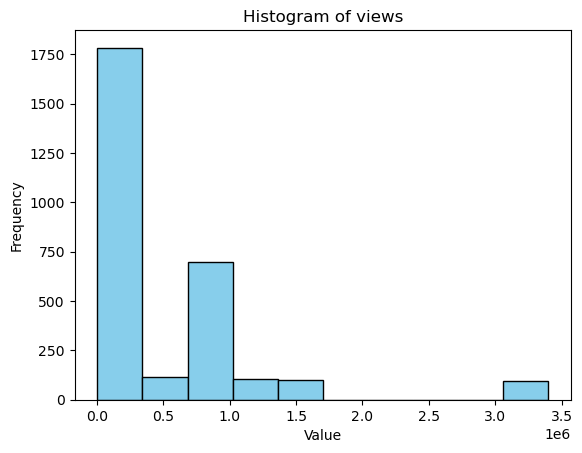

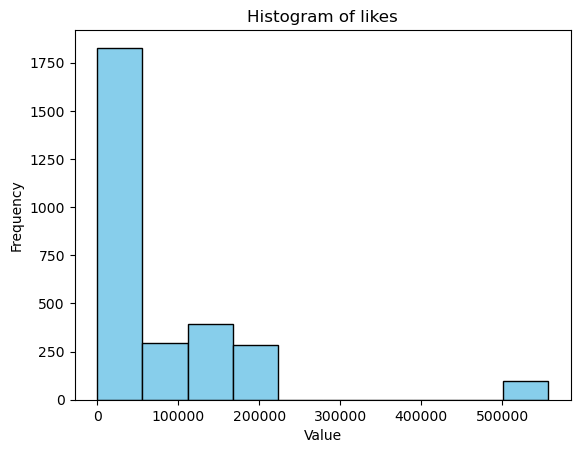

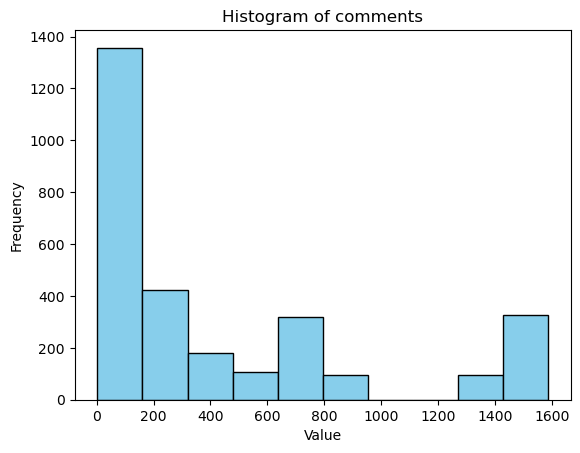

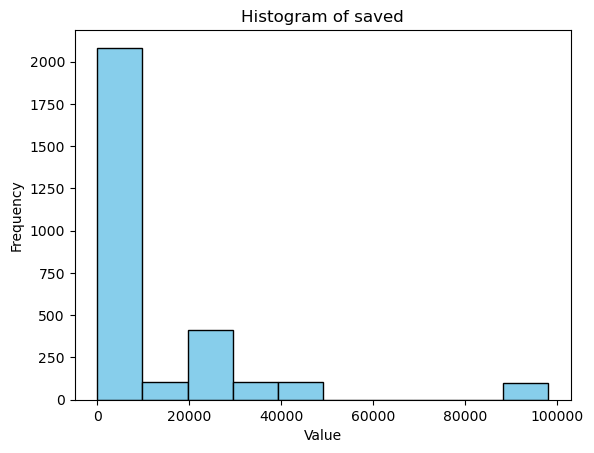

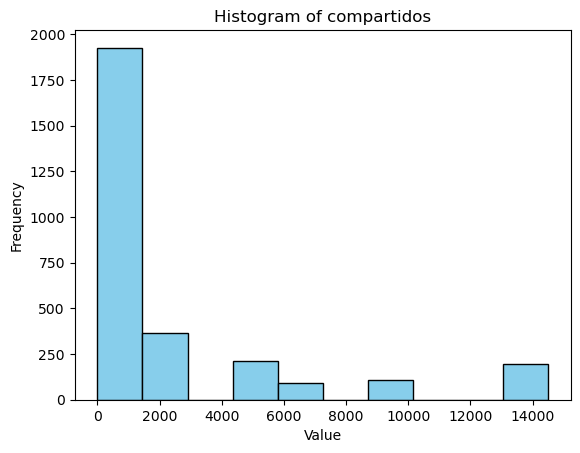

In [48]:
histograms = plot_hist(new_df,['views','likes','comments','saved','compartidos'])